In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

c:\Users\BeiFeng\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:

df = pd.read_csv('train/rate.csv')[['date', 'OT']]  # 因为我的数据有多列，在这里我给这两列进行的单独提取出来
df.head(2)

,date,OT
0,1/1/1990 0:00,0.593
1,1/2/1990 0:00,0.594


In [3]:
# 初始化标准化器
scaler = StandardScaler()
cols_data = df.columns[1:]
df_data = df[cols_data]
scaler.fit(df_data.values)
data_scaled = scaler.transform(df_data.values)

In [4]:
# 将时间列转换为 DataFrame
df_time = pd.DataFrame(df['date'])  # 假设时间列名为'date'
df_scaled_with_time = pd.concat([df_time, pd.DataFrame(data_scaled, columns=cols_data)], axis=1)

In [5]:
l = int(len(df)*0.2)
train = df_scaled_with_time[:-l]
test = df_scaled_with_time[-l:]
len(test)

1499

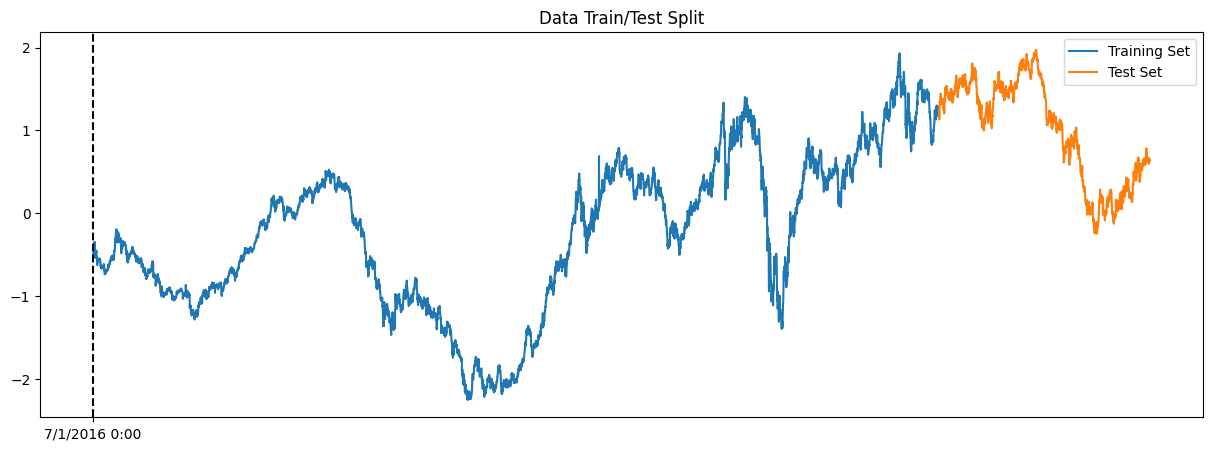

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('7/1/2016 0:00', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [7]:
# 这里需要将你的时间列和数据列进行重命名因为Prophet需要的两列名字固定是ds 和 y
train.rename(columns={'date': 'ds', 'OT': 'y'}, inplace=True)
test.rename(columns={'date': 'ds', 'OT': 'y'}, inplace=True)

C:\Users\BeiFeng\AppData\Local\Temp\ipykernel_25552\3054937913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.rename(columns={'date': 'ds', 'OT': 'y'}, inplace=True)
C:\Users\BeiFeng\AppData\Local\Temp\ipykernel_25552\3054937913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.rename(columns={'date': 'ds', 'OT': 'y'}, inplace=True)


In [8]:
# 初始化Prophet模型
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
# 拟合模型
model.fit(train)

18:09:55 - cmdstanpy - INFO - Chain [1] start processing
18:10:01 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# 创建未来日期的数据框
future = model.make_future_dataframe(periods=l, freq='D')

In [14]:
# 进行预测
forecast = model.predict(future)

In [15]:
forecast.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1990-01-01,-0.474966,-0.675511,-0.025566,-0.474966,-0.474966,0.124909,0.124909,0.124909,0.084796,...,-0.001261,-0.001261,-0.001261,0.041374,0.041374,0.041374,0.0,0.0,0.0,-0.350057
1,1990-01-02,-0.475833,-0.653532,-0.037058,-0.475833,-0.475833,0.124720,0.124720,0.124720,0.084796,...,0.000091,0.000091,0.000091,0.039833,0.039833,0.039833,0.0,0.0,0.0,-0.351113


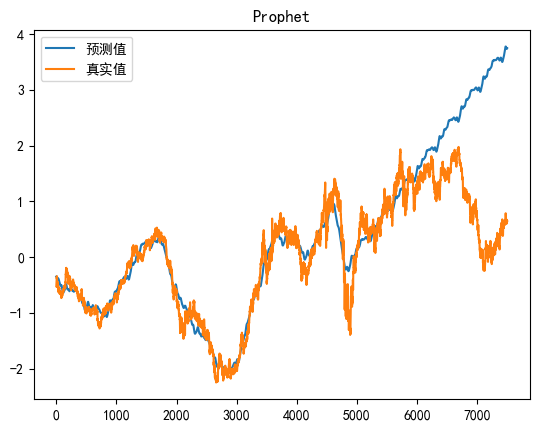

In [16]:
plt.rcParams['font.sans-serif'] = ['Kaitt', 'SimHei']
plt.figure()
plt.plot(forecast['yhat'], label='预测值')
plt.plot(df_scaled_with_time['OT'], label='真实值')
plt.title('Prophet')
plt.legend()
plt.rcParams['axes.unicode_minus'] = False
plt.show()

In [13]:
from metrics import metric
# 计算MSE和MAE
mae, mse, rmse, mape, mspe = metric(forecast['yhat'], test['y'])
# test_mse = mean_squared_error(test_result['y'], test_result['yhat'])
# test_mae = mean_absolute_error(test_result['y'], test_result['yhat'])

print(f"验证集 MSE: {mse}, MAE: {mae}")
# print(f"测试集 MSE: {test_mse}, MAE: {test_mae}")

验证集 MSE: 4.165516083268927, MAE: 1.6682021920664323
